In [1]:
from COIN_Python.coin import COIN

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Test Modules
## Test COIN

Simulting the COIN model


  0%|          | 0/1 [00:00<?, ?it/s]e:\Projects\COINRL\COIN_Python\coin.py:600: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"]) + np.log(coin_state["probability_state_feedback"])
e:\Projects\COINRL\COIN_Python\utils\general_utils.py:43: RuntimeWarning: divide by zero encountered in log
  log_weights = np.log(weights)
e:\Projects\COINRL\COIN_Python\coin.py:607: RuntimeWarning: divide by zero encountered in log
  p_c = np.log(coin_state["prior_probabilities"])
100%|██████████| 1/1 [00:08<00:00,  8.25s/it]


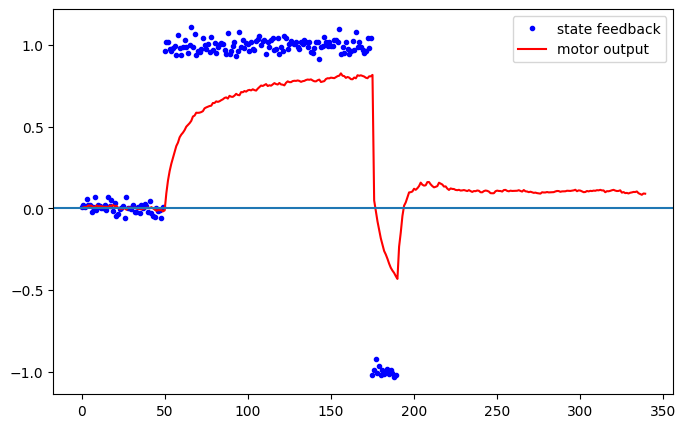

In [2]:
# Test COIN_Python
retention_values = np.linspace(0.8, 1, 500, endpoint=True)
drift_values = np.linspace(-0.1, 0.1, 500, endpoint=True)
state_values = np.linspace(-1.5, 1.5, 500, endpoint=True)
bias_values = np.linspace(-1.5, 1.5, 500, endpoint=True)
state_feedback_values = np.linspace(-1.5, 1.5, 500, endpoint=True)

store = [
    "state_feedback", "motor_output", "responsibilities", 
]

coin_model = COIN(
    retention_values=retention_values, 
    drift_values=drift_values, 
    state_values=state_values, 
    bias_values=bias_values, 
    state_feedback_values=state_feedback_values, 
    store=store, 
) # use default parameters for now
coin_model.perturbations = np.concatenate([
    np.zeros((50, )), 
    np.ones((125, )), 
    -np.ones((15, )), 
    np.ones((150, )) * np.nan, 
])

output = coin_model.simulate_coin()

plt.figure(figsize=(8, 5))
plt.plot(output["runs"][0]["state_feedback"], "b.", label="state feedback")
plt.plot(output["runs"][0]["motor_output"], "r", label="motor output")
plt.legend()
plt.axhline(0)

## Test Gymnasium and RL
### Q-Learning

Training and Visualising

In [3]:
import gymnasium as gym
import numpy as np

# 1. Create the MountainCar environment
env = gym.make("MountainCar-v0", render_mode=None)

# 2. Discretization settings
num_position_bins = 30
num_velocity_bins = 30

position_min, position_max = -1.2, 0.6
velocity_min, velocity_max = -0.07, 0.07

# Create the bins
position_bins = np.linspace(position_min, position_max, num_position_bins)
velocity_bins = np.linspace(velocity_min, velocity_max, num_velocity_bins)

def discretize_state(observation):
    """Discretize the continuous state into a tuple of (pos_index, vel_index)."""
    position, velocity = observation
    
    # Find the discretized index for position
    pos_index = np.digitize(position, position_bins) - 1
    # Clip to ensure within [0, num_position_bins - 1]
    pos_index = min(num_position_bins - 1, max(0, pos_index))
    
    # Find the discretized index for velocity
    vel_index = np.digitize(velocity, velocity_bins) - 1
    # Clip to ensure within [0, num_velocity_bins - 1]
    vel_index = min(num_velocity_bins - 1, max(0, vel_index))
    
    return (pos_index, vel_index)

# 3. Initialize the Q-table: shape [num_position_bins, num_velocity_bins, action_space]
n_actions = env.action_space.n
Q = np.zeros((num_position_bins, num_velocity_bins, n_actions))

# 4. Hyperparameters
alpha = 0.1      # Learning rate
gamma = 0.99     # Discount factor
epsilon = 1.0    # Initial epsilon for exploration
epsilon_decay = 0.999  # Decay for epsilon after each episode
min_epsilon = 0.01

n_episodes = 5000
max_steps_per_episode = 200  # env._max_episode_steps is typically 200 for MountainCar

all_episode_rewards = []

for episode in range(n_episodes):
    # Reset environment and get initial observation
    obs, _ = env.reset()
    state = discretize_state(obs)
    episode_reward = 0
    
    for step in range(max_steps_per_episode):
        # \epsilon-greedy action selection
        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(Q[state])
        
        # Take the chosen action
        next_obs, reward, done, truncated, info = env.step(action)
        
        # Discretize next state
        next_state = discretize_state(next_obs)
        
        # Q-learning update
        best_next_action = np.argmax(Q[next_state])
        td_target = reward + gamma * Q[next_state][best_next_action]
        Q[state][action] += alpha * (td_target - Q[state][action])
        
        state = next_state
        episode_reward += reward
        
        if done or truncated:
            break
    
    # Decay epsilon
    epsilon = max(min_epsilon, epsilon * epsilon_decay)
    all_episode_rewards.append(episode_reward)

    # Optional: print some debug info
    if (episode + 1) % 500 == 0:
        avg_reward = np.mean(all_episode_rewards[-500:])
        print(f"Episode: {episode + 1}, Average Reward (last 500): {avg_reward:.2f}, Epsilon: {epsilon:.3f}")

env.close()

# After training, you can watch the policy in action by setting render_mode="human" 
# and letting it run a few episodes. Remember to set epsilon=0.0 to watch the greedy policy.


Episode: 500, Average Reward (last 500): -200.00, Epsilon: 0.606
Episode: 1000, Average Reward (last 500): -200.00, Epsilon: 0.368
Episode: 1500, Average Reward (last 500): -199.92, Epsilon: 0.223
Episode: 2000, Average Reward (last 500): -199.18, Epsilon: 0.135
Episode: 2500, Average Reward (last 500): -196.02, Epsilon: 0.082
Episode: 3000, Average Reward (last 500): -196.60, Epsilon: 0.050
Episode: 3500, Average Reward (last 500): -186.90, Epsilon: 0.030
Episode: 4000, Average Reward (last 500): -179.49, Epsilon: 0.018
Episode: 4500, Average Reward (last 500): -179.30, Epsilon: 0.011
Episode: 5000, Average Reward (last 500): -194.61, Epsilon: 0.010


Visualisation

In [ ]:
from environments import CustomMountainCarEnv

def run_trained_policy(Q, 
                       position_bins, 
                       velocity_bins, 
                       num_episodes=5):
    """Visualize the trained policy in MountainCar-v0."""
    
    def discretize_state(obs):
        """Discretize continuous (position, velocity) into Q-table indices."""
        position, velocity = obs

        pos_index = np.digitize(position, position_bins) - 1
        pos_index = min(len(position_bins) - 1, max(0, pos_index))

        vel_index = np.digitize(velocity, velocity_bins) - 1
        vel_index = min(len(velocity_bins) - 1, max(0, vel_index))

        return (pos_index, vel_index)

    # Create the environment with rendering
    env = CustomMountainCarEnv(amplitude=1.0, force_sf=1.0, render_mode="human")

    for episode in range(num_episodes):
        obs, _ = env.reset()
        state = discretize_state(obs)
        done = False
        truncated = False
        
        episode_reward = 0
        while not (done or truncated):
            # Greedy action selection (epsilon = 0)
            action = np.argmax(Q[state])
            
            # Step
            next_obs, reward, done, truncated, _ = env.step(action)
            episode_reward += reward
            
            # Update state
            next_state = discretize_state(next_obs)
            state = next_state
        
        print(f"Episode {episode + 1} ended with total reward: {episode_reward}")

    env.close()

run_trained_policy(Q, position_bins, velocity_bins, num_episodes=1)


Episode 1 ended with total reward: -112.0


### PPO
Training and Importing

In [ ]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
import numpy as np
import collections

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters (you can tune these)
learning_rate = 3e-4
gamma = 0.99
gae_lambda = 0.95
clip_epsilon = 0.2
ppo_epochs = 10
num_episodes = 200
rollout_steps = 2048
mini_batch_size = 64

# Actor-Critic network
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=64):
        super(ActorCritic, self).__init__()
        
        # Common feature extractor
        self.common = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
        )
        
        # Actor head
        self.mu = nn.Linear(hidden_dim, action_dim)
        self.log_std_param = nn.Parameter(torch.zeros(action_dim))
        
        # Critic head
        self.critic = nn.Linear(hidden_dim, 1)
        
    def forward(self, state):
        x = self.common(state)
        mu = self.mu(x)
        log_std = self.log_std_param
        value = self.critic(x)
        return mu, log_std, value
    
    def get_action(self, state):
        with torch.no_grad():
            mu, log_std, _ = self.forward(state)
            dist = Normal(mu, log_std.exp())
            action = dist.sample()
        return action.cpu().numpy(), dist.log_prob(action).sum(dim=-1).cpu().numpy()
    
    def evaluate_actions(self, states, actions):
        mu, log_std, value = self.forward(states)
        dist = Normal(mu, log_std.exp())
        
        log_probs = dist.log_prob(actions).sum(dim=-1)
        entropy = dist.entropy().sum(dim=-1)
        return log_probs, entropy, value.squeeze(-1)

# Replay buffer for PPO
class PPOMemory:
    def __init__(self):
        self.states = []
        self.actions = []
        self.log_probs = []
        self.rewards = []
        self.dones = []
        self.values = []
    
    def store(self, state, action, log_prob, reward, done, value):
        self.states.append(state)
        self.actions.append(action)
        self.log_probs.append(log_prob)
        self.rewards.append(reward)
        self.dones.append(done)
        self.values.append(value)
    
    def clear(self):
        self.states = []
        self.actions = []
        self.log_probs = []
        self.rewards = []
        self.dones = []
        self.values = []

def compute_gae(next_value, rewards, dones, values):
    """
    Computes Generalized Advantage Estimation (GAE)
    """
    advantages = []
    gae = 0
    for i in reversed(range(len(rewards))):
        delta = rewards[i] + gamma * (1 - dones[i]) * next_value - values[i]
        gae = delta + gamma * gae_lambda * (1 - dones[i]) * gae
        advantages.insert(0, gae)
        next_value = values[i]
    return advantages

# Instantiate environment and model
env = gym.make("Pendulum-v1")
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]

agent = ActorCritic(obs_dim, act_dim).to(device)
optimizer = optim.Adam(agent.parameters(), lr=learning_rate)

memory = PPOMemory()

# Training loop
episode_rewards = []

for episode in range(num_episodes):
    state, _ = env.reset()
    done = False
    ep_reward = 0
    
    for t in range(rollout_steps):
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            mu, log_std, value = agent.forward(state_tensor)
            dist = Normal(mu, log_std.exp())
            action = dist.sample()
            log_prob = dist.log_prob(action).sum(dim=-1)
        
        action_clipped = action.cpu().numpy()[0]
        next_state, reward, done, truncated, info = env.step(action_clipped)
        
        memory.store(
            state,
            action_clipped,
            log_prob.item(),
            reward,
            float(done or truncated),
            value.item()
        )
        
        state = next_state
        ep_reward += reward
        if done or truncated:
            break
    
    episode_rewards.append(ep_reward)
    
    # Compute advantage for the collected rollout
    # Note: if we ended due to done/truncated, next_value is typically 0 or the critic's estimate of the next_state
    next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0).to(device)
    with torch.no_grad():
        _, _, next_value = agent.forward(next_state_tensor)
    next_value = next_value.item()
    
    advantages = compute_gae(next_value,
                             memory.rewards,
                             memory.dones,
                             memory.values)
    returns = [adv + val for adv, val in zip(advantages, memory.values)]
    
    # Convert rollout to tensors
    states = torch.FloatTensor(memory.states).to(device)
    actions = torch.FloatTensor(memory.actions).to(device)
    old_log_probs = torch.FloatTensor(memory.log_probs).to(device)
    advantages = torch.FloatTensor(advantages).to(device)
    returns = torch.FloatTensor(returns).to(device)
    
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
    
    # PPO update
    dataset_size = len(states)
    for _ in range(ppo_epochs):
        # Shuffle indices for mini-batches
        indices = np.arange(dataset_size)
        np.random.shuffle(indices)
        
        for start in range(0, dataset_size, mini_batch_size):
            end = start + mini_batch_size
            mb_indices = indices[start:end]
            
            mb_states = states[mb_indices]
            mb_actions = actions[mb_indices]
            mb_old_log_probs = old_log_probs[mb_indices]
            mb_advantages = advantages[mb_indices]
            mb_returns = returns[mb_indices]
            
            log_probs, entropy, value = agent.evaluate_actions(mb_states, mb_actions)
            ratio = torch.exp(log_probs - mb_old_log_probs)
            
            surr1 = ratio * mb_advantages
            surr2 = torch.clamp(ratio, 1.0 - clip_epsilon, 1.0 + clip_epsilon) * mb_advantages
            actor_loss = -torch.min(surr1, surr2).mean()
            
            critic_loss = nn.MSELoss()(value, mb_returns)
            
            loss = 0.5 * critic_loss + actor_loss - 0.01 * entropy.mean()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
    memory.clear()
    
    print(f"Episode {episode+1}/{num_episodes}, Reward: {ep_reward:.2f}")

env.close()

print("Training finished.")
print("Episode rewards:", episode_rewards)


Visualising

In [ ]:
import gymnasium as gym

env = gym.make("Pendulum-v1", render_mode="human")  # or 'rgb_array' in some environments
state, _ = env.reset()
done = False

while not done:
    state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
    action, _ = agent.get_action(state_tensor)
    action = action[0]
    state, reward, done, truncated, info = env.step(action)
    if done or truncated:
        break

env.close()
